# Load Packages

In [1]:
# Load packages
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import plotly.graph_objs as go
import statistics
import plotly.express as px
from plotly.subplots import make_subplots

# For PCA / clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Set plotting style
plt.style.use('dark_background')

# Read Data

In [2]:
# Read in data
data = pd.read_csv(r'/Users/robertbanks/Desktop/Projects/FIFA_Rating/male_players.csv', low_memory = False)

In [3]:
# Create player position categories for more uniformity
# Create column in data for the first position listed for each player
positions = data['player_positions']
first_position = []
level1_position = []
level2_position = []
level3_position = []


i = 0
for player_row in positions:
    # Create data column for first position listed for each player
    player_positions = positions[i].split(',')
    first = player_positions[0].strip()
    level1_position.append((first).strip())
    
    # Create data column for broad position classification based on first_position
    # Create data column for even broader position classifications
    if (first == 'ST'):
        level2_position.append('Striker')
        level3_position.append('Center_Forward')
    elif (first == 'CF'):
        level2_position.append('Center_Forward')
        level3_position.append('Center_Forward')
    elif (first == 'LM') | (first == 'LW') | (first == 'RM') | (first == 'RW'):
        level2_position.append('Wide_Player')
        level3_position.append('Wide_Player')
    elif (first == 'CAM'):
        level2_position.append('Attacking_Midfielder')
        level3_position.append('Central_Midfielder')
    elif (first == 'CM'):
        level2_position.append('Central_Midfielder')
        level3_position.append('Central_Midfielder')
    elif (first == 'CDM'):
        level2_position.append('Defensive_Midfielder')
        level3_position.append('Central_Midfielder')
    elif (first == 'CB'):
        level2_position.append('Central_Defender')
        level3_position.append('Central_Defender')
    elif (first == 'LWB') | (first == 'LB') | (first == 'RWB') | (first == 'RB'):
        level2_position.append('Fullback')
        level3_position.append('Fullback')
    elif (first == 'GK'):
        level2_position.append('Goalkeeper')
        level3_position.append('Goalkeeper')
    else:
        level2_position.append('XXX')
        level3_position.append('XXX')
        
    i += 1
    
data['level1_position'] = level1_position
data['level2_position'] = level2_position
data['level3_position'] = level3_position



# Set Up Data for PCA

In [4]:
# Subset data for overall >= 75 and no goalkeepers 
data_75 = data[(data.overall >= 75) & (data.player_positions != 'GK')]

# Ensure each player id only shows up in data once
# Create list of unique player_ids
players = np.unique(data_75['player_id'])

In [5]:
# Want to ensure that each player id only shows up once
data_75_unique = pd.DataFrame()

for id in players:
    temp = data_75[data_75['player_id'] == id].sort_values(by = 'overall', ascending = False)[:1]
    data_75_unique = pd.concat([data_75_unique, temp])

In [6]:
# Work rate given as 'Attacking / Defensive'
# Split into separate columns for each type
attack_wr = []
defense_wr = []

for workrate in data_75_unique['work_rate']:
    attack_wr.append(workrate.split('/')[0])
    defense_wr.append(workrate.split('/')[1])
    
data_75_unique['attack_work_rate'] = attack_wr
data_75_unique['defense_work_rate'] = defense_wr
    
# Create list of variables not used for PCA
# Or used in PCA and also needed for below analysis
other_variables = ['player_id', 'short_name', 'long_name', 'fifa_version', 'player_positions', 
                  'overall', 'potential','value_eur', 'wage_eur', 'age', 'club_team_id', 
                  'club_name', 'league_id', 'league_name', 'nationality_id',
                  'nationality_name', 'player_tags', 'player_traits', 'attack_work_rate',
                  'defense_work_rate', 'international_reputation', 'pace', 'shooting',
                  'passing', 'dribbling', 'defending', 'physic', 'skill_moves', 'weak_foot',
                   'international_reputation','level1_position', 'level2_position', 'level3_position']



In [7]:
# Create lists for columns to later subset data into narrow and broad categories
# Using only continuous variables

col_narrow = ['height_cm','weight_kg', 'attacking_crossing','attacking_finishing', 
                   'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 
                  'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
                  'mentality_penalties', 'mentality_composure', 'defending_marking_awareness',
                  'defending_standing_tackle', 'defending_sliding_tackle']

col_broad = ['height_cm','weight_kg','pace','shooting','passing','dribbling','defending',
                    'physic']

# Remove na values
# Convert data type in data to int (only incl quantiative cols)
# Scale to mean 0 and std 1 for PCA
# Convert scaled data from array to df
def pca_prep(df, col_list, col_type):
    subset = df[col_list].dropna().astype(int)
    scaler = StandardScaler(with_std = True, with_mean = True)
    subset_scaled = scaler.fit_transform(subset)
    df_scaled = pd.DataFrame(data = subset_scaled, columns = col_list)
    print('Mean of scaled data, {}: '.format(col_type), round(subset_scaled.mean()))
    print('Std dev of scaled data, {}: '.format(col_type), round(math.sqrt(subset_scaled.var())))
    print()
    return df_scaled

data_75_narrow_scaled = pca_prep(data_75_unique, col_narrow, 'narrow')
data_75_broad_scaled = pca_prep(data_75_unique, col_broad, 'broad')


Mean of scaled data, narrow:  0
Std dev of scaled data, narrow:  1

Mean of scaled data, broad:  0
Std dev of scaled data, broad:  1



# Fit PCA Model, Assign Clusters, and Plot

#### *Which set of columns should we use for clustering?*

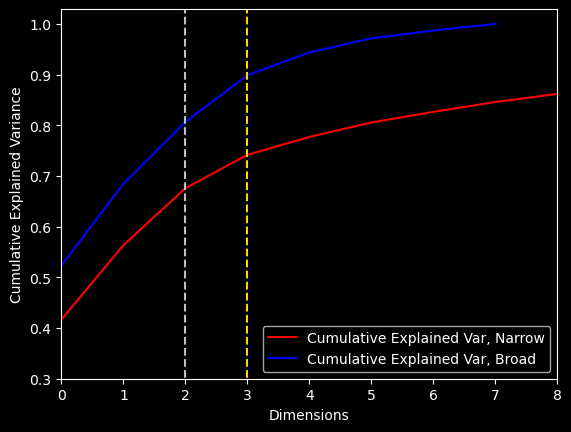

In [8]:
# Fit PCA model for data_75_narrow_scaled
pca_narrow = PCA()
pca_narrow_fit = pca_narrow.fit(data_75_narrow_scaled)

# Fit PCA model for data_75_broad_scaled
pca_broad = PCA()
pca_broad_fit = pca_broad.fit(data_75_broad_scaled)

# Create cumulative sum variable 
# Will be used to plot explained variance ratios
# And compared between narrow and broad
cum_sum_n = np.cumsum(pca_narrow_fit.explained_variance_ratio_)
cum_sum_b = np.cumsum(pca_broad_fit.explained_variance_ratio_)

# Plot cummulative sum ratios together
fig, ax = plt.subplots()
ax.plot(cum_sum_n, label = 'Cumulative Explained Var, Narrow', c = 'red')
ax.plot(cum_sum_b, label = 'Cumulative Explained Var, Broad', c = 'blue')
ax.set(xlabel = 'Dimensions', ylabel = 'Cumulative Explained Variance')
plt.legend(loc = 'lower right')
plt.ylim(.3)
plt.xlim(0,8)
plt.vlines(2,0,2, linestyle = '--', colors = 'silver')
plt.vlines(3,0,2, linestyle = '--', colors = 'gold')


#### **Based on above plot, we should use broad columns for PCA bc this set of columns explains more of the variance using three dimensions.**

#### *How many clusters should we use?*

In [9]:
# We have determined that we should use the broad data with 2 dimensions
# Refit PCA model
pca = PCA(n_components = 3)
pca_broad_3 = pca.fit_transform(data_75_broad_scaled)

# Convert to df
pca_broad_3_df = pd.DataFrame(data = pca_broad_3)

# Run KMeans for cluster counts from 2-10
cluster_count = []
inertia = []
sil_scores = []
for k in range (2,15):
    kmeans = KMeans(n_clusters = k, n_init = 1000)
    clusters = kmeans.fit_predict(pca_broad_3_df)
    cluster_count.append(k)
    inertia.append(kmeans.inertia_)
    sil = silhouette_score(pca_broad_3_df, clusters)
    sil_scores.append(sil)

[Text(0.5, 0, 'Cluster Count'), Text(0, 0.5, 'Inertia')]

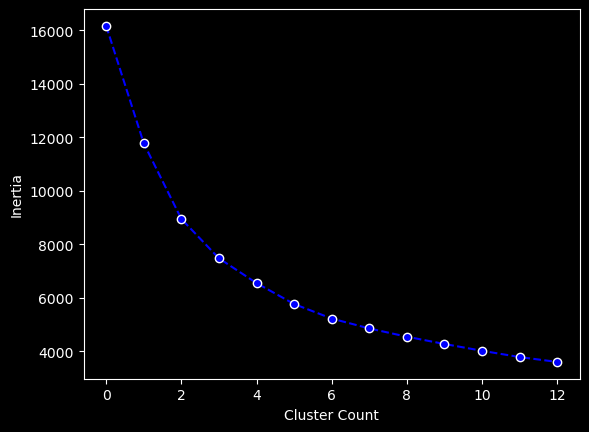

In [10]:
# Plot intertias versus num clusters
# Inertia is mean squared distance between each point and closest centroid
fig, ax = plt.subplots()
ax.plot(inertia, label = 'Inertia', c = 'blue', linestyle = '--', marker = 'o',
       markeredgecolor = 'white')
ax.set(xlabel = 'Cluster Count', ylabel = 'Inertia')
# plt.vlines(5,0,3000, linestyle = '--', colors = 'green')
# plt.vlines(12,0,3000, linestyle = '--', colors = 'green')

# Plot silhouette scores
# Silhouette score ranges \'from -1 to 1
# Equals (b-a) / max(a,b)
# a = mean intracluster distance
# b = mean intercluster distance
# Close to 1 means minimizing intracluster distance, maximizing intercluster distance
# Close to 0 means close to boundary
# Close to -1 means wrong cluster
# fig, ax = plt.subplots()
# ax.plot(sil_scores, label = 'Silhouette Score', c = 'purple')
# ax.set(xlabel = 'Cluster Count', ylabel = 'Silhouette Score')

[Text(0.5, 0, 'Cluster Count'), Text(0, 0.5, 'Deriv. of Inertia')]

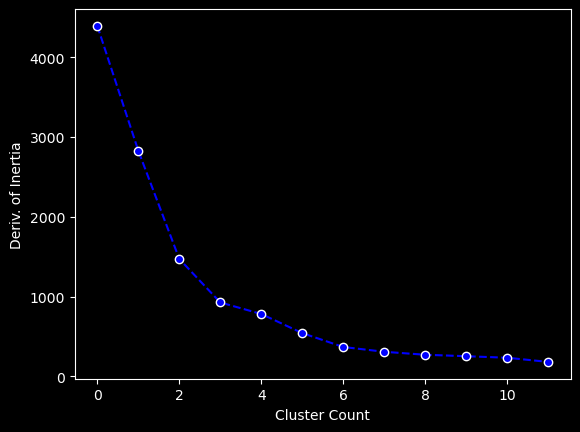

In [11]:
i = 0
j = len(inertia) - 1
chg_y = []

while i < j:
    slope = inertia[i] - inertia[i+1]
    chg_y.append(slope)
    i+=1
    
# Plot slopes of inertia points
fig, ax = plt.subplots()
ax.plot(chg_y, label = 'Deriv. of Inertia', c = 'blue', linestyle = '--', marker = 'o',
       markeredgecolor = 'white')
ax.set(xlabel = 'Cluster Count', ylabel = 'Deriv. of Inertia')

#### **Based on the above elbow plots, using 6 clusters is a reasonable approximation, as 6 is the cluster count at which the derivative of intertia noticably slows. However, the actual optimal cluster count is ambiguous given there isn't a sharp elbow in the plot.**
#### **Silhouette score may not be flawed because the data has clusters of differing densities and potentially non-spherical shapes.**

In [56]:
# # Fit kmeans model based on selection of n_clusters
# # Runs algorithm 1,000 times, keeps solution with lowest inertia
# kmeans_6 = KMeans(n_clusters = 6, n_init = 1000)
# clusters_6 = kmeans_6.fit_predict(pca_broad_3_df)

# # See locations of cluster centers
# centers = pd.DataFrame(data = kmeans_6.cluster_centers_)


# Prepare data so can plot principal components with player identification
# Drop row indeces in data_75[other_variables] so we can concat with pca data
# data_75_other_var = data_75_unique.reset_index(inplace = True)
# # Merge pca data with player-specific data for plotting
# merged_data = pd.concat([pca_broad_3_df, data_75_unique[other_variables]], axis=1)
# # Add column for cluster labels
# merged_data['kmeans_cluster'] = clusters_6

# Add column for discrete cluster labels
# Originally cluster labels are continous variables (not sure why)
merged_data['kmeans_cluster_discrete'] = np.where(merged_data['kmeans_cluster'] == 0, 0, 
                                                  np.where(merged_data['kmeans_cluster'] == 1, 1,
                                                          np.where(merged_data['kmeans_cluster'] == 2, 2,
                                                                  np.where(merged_data['kmeans_cluster'] == 3, 3, 
                                                                          np.where(merged_data['kmeans_cluster'] == 4, 4,
                                                                                  np.where(merged_data['kmeans_cluster'] == 5, 5, 'XXX')
                                                                                  )
                                                                          )
                                                                  )
                                                          )
                                                )


scatter_data = [
    go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 0][0],
        y = merged_data[merged_data['kmeans_cluster'] == 0][1],
        z = merged_data[merged_data['kmeans_cluster'] == 0][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'blue', 
            opacity = .08
        ),
        name = 'Cluster 0' 
    ),
    
     go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 1][0],
        y = merged_data[merged_data['kmeans_cluster'] == 1][1],
        z = merged_data[merged_data['kmeans_cluster'] == 1][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'red', 
            opacity = .08
        ),
        name = 'Cluster 1'
    ), 
    
    go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 2][0],
        y = merged_data[merged_data['kmeans_cluster'] == 2][1],
        z = merged_data[merged_data['kmeans_cluster'] == 2][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'green', 
            opacity = .08
        ),
        name = 'Cluster 2'
    ), 
    
        go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 3][0],
        y = merged_data[merged_data['kmeans_cluster'] == 3][1],
        z = merged_data[merged_data['kmeans_cluster'] == 3][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'purple', 
            opacity = .08
        ),
        name = 'Cluster 3'
    ), 
    
        go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 4][0],
        y = merged_data[merged_data['kmeans_cluster'] == 4][1],
        z = merged_data[merged_data['kmeans_cluster'] == 4][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'orange', 
            opacity = .08
        ),
        name = 'Cluster 4'
    ),
    
     go.Scatter3d(
        x = merged_data[merged_data['kmeans_cluster'] == 5][0],
        y = merged_data[merged_data['kmeans_cluster'] == 5][1],
        z = merged_data[merged_data['kmeans_cluster'] == 5][2], 
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'cyan', 
            opacity = .08
        ),
        name = 'Cluster 5'
    ),
                
    go.Scatter3d(
        x = centers[0],
        y = centers[1],
        z = centers[2],
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'black',#'red', 
            symbol = 'cross',
            line = dict(
                color = 'white',
                width = .5
            ),
        ),
        name = 'Centroids'
    ), 
]

fig = go.Figure(data = scatter_data)

fig.update_layout(template = 'plotly_dark')

fig.show()

# Explore kmeans model results
total = 0
for i in range(0,6):
    obs = np.count_nonzero(kmeans_6.labels_ == i)
    pct_obs = obs / len(pca_broad_3_df)
    total += obs
    print('Cluster Number: {}'.format(i), '| Num Observations: {}'.format(obs),
          '| % Observations: {:.2%}'.format(pct_obs))
    


Cluster Number: 0 | Num Observations: 933 | % Observations: 21.07%
Cluster Number: 1 | Num Observations: 436 | % Observations: 9.84%
Cluster Number: 2 | Num Observations: 754 | % Observations: 17.02%
Cluster Number: 3 | Num Observations: 964 | % Observations: 21.77%
Cluster Number: 4 | Num Observations: 532 | % Observations: 12.01%
Cluster Number: 5 | Num Observations: 810 | % Observations: 18.29%


In [13]:
# Explore ratings by category for each cluster
# Average ratings by category

category = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
cluster_avg_pac = []
cluster_avg_sho = []
cluster_avg_pas = []
cluster_avg_dri = []
cluster_avg_def = []
cluster_avg_phy = []


i = 0
for cluster_count in range (0,6):
    temp = merged_data[merged_data['kmeans_cluster'] == cluster_count]
    
    avg_pace = statistics.mean(temp[category[i]])
    cluster_avg_pac.append(avg_pace)
    
    avg_shooting = statistics.mean(temp[category[i+1]])
    cluster_avg_sho.append(avg_shooting)
                           
    avg_passing = statistics.mean(temp[category[i+2]])
    cluster_avg_pas.append(avg_passing)
    
    avg_dribbling = statistics.mean(temp[category[i+3]])
    cluster_avg_dri.append(avg_dribbling)
    
    avg_defending = statistics.mean(temp[category[i+4]])
    cluster_avg_def.append(avg_defending)

    avg_physic = statistics.mean(temp[category[i+5]])
    cluster_avg_phy.append(avg_physic)
    
    print('Averages for Cluster Number {}:'.format(cluster_count), 
          '| PAC: {:.0f}'.format(cluster_avg_pac[cluster_count]),
          '| SHO: {:.0f}'.format(cluster_avg_sho[cluster_count]), 
          '| PAS: {:.0f}'.format(cluster_avg_pas[cluster_count]),
          '| DRI: {:.0f}'.format(cluster_avg_dri[cluster_count]), 
          '| DEF: {:.0f}'.format(cluster_avg_def[cluster_count]),
          '| PHY: {:.0f}'.format(cluster_avg_phy[cluster_count]))
    

Averages for Cluster Number 0: | PAC: 82 | SHO: 72 | PAS: 73 | DRI: 81 | DEF: 41 | PHY: 59
Averages for Cluster Number 1: | PAC: 75 | SHO: 63 | PAS: 74 | DRI: 76 | DEF: 71 | PHY: 72
Averages for Cluster Number 2: | PAC: 72 | SHO: 77 | PAS: 64 | DRI: 73 | DEF: 36 | PHY: 77
Averages for Cluster Number 3: | PAC: 61 | SHO: 42 | PAS: 56 | DRI: 57 | DEF: 78 | PHY: 78
Averages for Cluster Number 4: | PAC: 68 | SHO: 63 | PAS: 72 | DRI: 72 | DEF: 75 | PHY: 78
Averages for Cluster Number 5: | PAC: 79 | SHO: 75 | PAS: 73 | DRI: 79 | DEF: 40 | PHY: 68


In [114]:
# Explore ratings by category for each cluster
# Average ratings by category

category = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
cluster_med_pac = []
cluster_med_sho = []
cluster_med_pas = []
cluster_med_dri = []
cluster_med_def = []
cluster_med_phy = []


i = 0
for cluster_count in range (0,6):
    temp = merged_data[merged_data['kmeans_cluster'] == cluster_count]
    
    med_pace = statistics.median(temp[category[i]])
    cluster_med_pac.append(med_pace)
    
    med_shooting = statistics.median(temp[category[i+1]])
    cluster_med_sho.append(med_shooting)
                           
    med_passing = statistics.median(temp[category[i+2]])
    cluster_med_pas.append(med_passing)
    
    med_dribbling = statistics.median(temp[category[i+3]])
    cluster_med_dri.append(med_dribbling)
    
    med_defending = statistics.median(temp[category[i+4]])
    cluster_med_def.append(med_defending)
    
    med_physic = statistics.median(temp[category[i+5]])
    cluster_med_phy.append(med_physic)
    
    print('Medians for Cluster Number {}:'.format(cluster_count), 
          '| PAC: {:.0f}'.format(cluster_med_pac[cluster_count]),
          '| SHO: {:.0f}'.format(cluster_med_sho[cluster_count]), 
          '| PAS: {:.0f}'.format(cluster_med_pas[cluster_count]),
          '| DRI: {:.0f}'.format(cluster_med_dri[cluster_count]), 
          '| DEF: {:.0f}'.format(cluster_med_def[cluster_count]),
          '| PHY: {:.0f}'.format(cluster_med_phy[cluster_count]))
    

Medians for Cluster Number 0: | PAC: 82 | SHO: 72 | PAS: 73 | DRI: 80 | DEF: 39 | PHY: 59
Medians for Cluster Number 1: | PAC: 76 | SHO: 64 | PAS: 73 | DRI: 76 | DEF: 72 | PHY: 72
Medians for Cluster Number 2: | PAC: 73 | SHO: 77 | PAS: 64 | DRI: 73 | DEF: 35 | PHY: 77
Medians for Cluster Number 3: | PAC: 63 | SHO: 41 | PAS: 57 | DRI: 58 | DEF: 78 | PHY: 78
Medians for Cluster Number 4: | PAC: 69 | SHO: 64 | PAS: 72 | DRI: 73 | DEF: 75 | PHY: 78
Medians for Cluster Number 5: | PAC: 79 | SHO: 75 | PAS: 73 | DRI: 79 | DEF: 39 | PHY: 68


In [61]:
# Plot radar charts to visualize average ratings for each category by cluster
# Set up data
average_rating_lists = [cluster_avg_pac, cluster_avg_sho, 
                        cluster_avg_pas, cluster_avg_dri, 
                       cluster_avg_def, cluster_avg_phy]

cluster0_ratings = []
cluster1_ratings = []
cluster2_ratings = []
cluster3_ratings = []
cluster4_ratings = []
cluster5_ratings = []

for list in average_rating_lists:
    cluster0_ratings.append(list[0])
    cluster1_ratings.append(list[1])
    cluster2_ratings.append(list[2])
    cluster3_ratings.append(list[3])
    cluster4_ratings.append(list[4])
    cluster5_ratings.append(list[5])

In [67]:
cluster_rating_lists = [cluster0_ratings, cluster1_ratings,
                       cluster2_ratings, cluster3_ratings,
                       cluster4_ratings, cluster5_ratings]

rating_categories = ['Pace', 'Shooting', 'Passing', 'Dribbling',
                     'Defending', 'Physical']

cluster_ratings_df = pd.DataFrame()

i = 0
for list in cluster_rating_lists:
    temp = pd.DataFrame(list, columns = ['Rating'])
    temp['Category'] = rating_categories
    temp['Cluster'] = i
    cluster_ratings_df = pd.concat([cluster_ratings_df, temp])
    i += 1

In [112]:
# Plot all clusters together

fig = px.line_polar(
    cluster_ratings_df,
    r = 'Rating',
    theta = 'Category',
    color = 'Cluster',
    range_r = (40,90), 
    line_close = True)

fig.update_layout(template = 'plotly_dark', showlegend = True, 
                  title = 'Cluster Average Ratings')
fig.update_polars(angularaxis_showgrid = True)
fig.show()

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future ve

In [152]:
# Create df for scatter polar
# Need columns for rating, category, player name, cluster number
cols = ['player_id', 'short_name', 'kmeans_cluster', 'pace', 'shooting',
       'dribbling', 'passing', 'defending', 'physic']

scatter_polar_df = merged_data[cols]


In [153]:
scatter_polar_df

,player_id,short_name,kmeans_cluster,pace,shooting,dribbling,passing,defending,physic
0,41,Iniesta,0,75.0,72.0,91.0,89.0,59.0,63.0
1,80,E. Belözoğlu,1,45.0,72.0,78.0,85.0,63.0,69.0
2,330,R. Keane,5,68.0,82.0,82.0,75.0,31.0,69.0
3,768,Felipe,3,40.0,35.0,52.0,51.0,78.0,63.0
4,1178,P. Cannavaro,3,34.0,44.0,52.0,52.0,78.0,70.0
...,...,...,...,...,...,...,...,...,...
4424,271673,Lázaro,5,79.0,71.0,75.0,69.0,43.0,61.0
4425,273106,Danilo,1,70.0,62.0,69.0,68.0,73.0,70.0
4426,273463,João Gomes,1,69.0,64.0,73.0,71.0,76.0,73.0
4427,273564,G. Orban,5,77.0,81.0,73.0,63.0,19.0,63.0


In [121]:
# Explore distribution of categories within each cluster

fig = px.scatter_polar(
    scatter_polar_df[scatter_polar_df['kmeans_cluster'] == 0],
    r = [,
    theta = 'Category',
    color = 'Cluster',
    range_r = (40,90))

fig.update_layout(template = 'plotly_dark', showlegend = True, 
                  title = 'Cluster Average Ratings')
fig.update_polars(angularaxis_showgrid = True)
fig.show()

In [14]:
level1_unique = np.unique(merged_data['level1_position'])
level1_unique_ordered = ['ST', 'CF', 'LW', 'RW', 'LM', 'RM', 'CAM', 'CM', 'CDM', 'CB','LB', 'LWB',
                         'RB', 'RWB']

cluster_count = np.unique(merged_data['kmeans_cluster'])
all_cluster_position_count = []


for position in level1_unique_ordered:
    for cluster in cluster_count:
        pos_sum = len(merged_data[(merged_data['level1_position'] == position) & (merged_data['kmeans_cluster'] == cluster)])
        all_cluster_position_count.append(pos_sum)

# All_cluster_position_count contains position counts for each position in each cluster
# First 6 values are for Striker, one for each cluster ranging from 0 - 5
# Create separate lists for each cluster based on index value
i = 0
cluster0_counts = all_cluster_position_count[0:len(all_cluster_position_count):6]
cluster1_counts = all_cluster_position_count[i+1:len(all_cluster_position_count):6]
cluster2_counts = all_cluster_position_count[i+2:len(all_cluster_position_count):6]
cluster3_counts = all_cluster_position_count[i+3:len(all_cluster_position_count):6]
cluster4_counts = all_cluster_position_count[i+4:len(all_cluster_position_count):6]
cluster5_counts = all_cluster_position_count[i+5:len(all_cluster_position_count):6]

# Combine cluster count lists into `dataframe for plotting
# In each list, add columns for positions and for cluster number
cluster_count_lists = [cluster0_counts, cluster1_counts, cluster2_counts, cluster3_counts,
                      cluster4_counts, cluster5_counts]

position_count_df = pd.DataFrame()

i = 0
for list in cluster_count_lists:
    temp = pd.DataFrame(list, columns = ['count'])
    temp['position'] = level1_unique_ordered
    temp['cluster'] = i
    position_count_df = pd.concat([position_count_df, temp])
    i += 1

In [16]:
# Plotting histograms of position count in each cluster
fig = px.histogram(position_count_df, x = 'position', y = 'count', color = 'cluster', 
                  labels = {
                      'cluster': 'Cluster'
                  })
fig.update_layout(template = 'plotly_dark', yaxis_title = 'Count', xaxis_title = 'Position')
fig.update_yaxes(showgrid = False)
fig.show()

In [57]:
# Comparing for each cluster
for i in range(0,6):
    fig = px.bar(position_count_df[position_count_df['cluster'] == i], 
                       x = 'position', 
                       y = 'count',
                       title = 'Cluster {} Composition'.format(i))
    fig.update_layout(template = 'plotly_dark', yaxis_title = 'Count', xaxis_title = 'Position', 
                     yaxis_range = [0,800])
    fig.update_yaxes(showgrid = False)
    fig.show()

# Resources


#### Keyboard shortcut for markdown
https://stackoverflow.com/questions/46168234/jupyter-markdown-not-working

#### Markdown formatting
https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax

#### Change Jupyter theme
#### https://chazf.medium.com/jupyter-dark-mode-themes-b242fb459254

#### Matplotlib style guide
#### https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html



# Domain Background

#### How FIFA ratings are calculated
https://www.goal.com/en-us/news/fifa-player-ratings-explained-how-are-the-card-number--stats-decided/1hszd2fgr7wgf1n2b2yjdpgynu